In [1]:
import os
import numpy as np # linear Algebra 
import pandas as pd # data processing, CSV file I/O
import matplotlib.pyplot as plt #creating static, animated, and interactive visualizations
import cv2 #image processing and performing computer vision tasks
%matplotlib inline
#will make your plot outputs appear and be stored within the notebook.
from plotly.subplots import make_subplots
import plotly.graph_objs as go

from sklearn.model_selection import train_test_split

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid



In [2]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
#downloading the dataset
labels=pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
submission = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
train_path='../input/histopathologic-cancer-detection/train/'
test_path='../input/histopathologic-cancer-detection/test/'

In [4]:
train,validation=train_test_split(labels,stratify=labels.label,test_size=0.2)
len(train), len(validation)


(176020, 44005)

**SIMPLE CUSTOM GENERATOR**


In [5]:
## Parameters for model

# Hyper parameters
num_epochs = 8
num_classes = 2
batch_size = 128
learning_rate = 0.002

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
class MyDataset(Dataset):
    def __init__(self,df_data,data_dir='./',transform=None):
        super().__init__()
        self.df=df_data.values
        self.data_dir=data_dir
        self.transform=transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,index):
        img_name,label=self.df[index]
        img_path=os.path.join(self.data_dir,img_name+'.tif')
        image=cv2.imread(img_path)
        if self.transform is not None:
            image=self.transform(image)
        return image,label

In [7]:
train_tfs=transforms.Compose([transforms.ToTensor()])

In [8]:
img_dataset = MyDataset(df_data=train,data_dir=train_path,transform=train_tfs) # Histopathalogic images

In [9]:
img,label=img_dataset[10]
print(img.shape,torch.min(img),torch.max(img))

torch.Size([3, 96, 96]) tensor(0.) tensor(1.)


In [10]:
import plotly.express as px

def plot_img(x,y):

    npimg = x.numpy() # convert tensor to numpy array
    npimg_tr=np.transpose(npimg, (1,2,0)) # Convert to H*W*C shape
    fig = px.imshow(npimg_tr)
    fig.update_layout(coloraxis_showscale=False,title=str(y_grid_train))
    fig.update_xaxes(showticklabels=False)
    fig.update_layout(template='plotly_white',height=200);fig.update_layout(margin={"r":0,"t":60,"l":0,"b":0})
    fig.update_layout(title={'text': str(y),'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'})
    
    fig.show()

image indices: [136150 109238  75347 142833 160117 151871  91133 103548]
torch.Size([3, 198, 394])



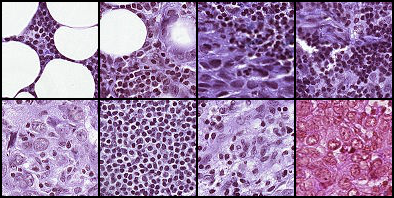

In [11]:
import plotly.express as px
from torchvision import utils
%matplotlib inline
import nilearn

# Create grid of sample images 
grid_size=8
rnd_inds=np.random.randint(0,len(img_dataset),grid_size)
print("image indices:",rnd_inds)

x_grid_train=[img_dataset[i][0] for i in rnd_inds]
y_grid_train=[img_dataset[i][1] for i in rnd_inds]

x_grid_train=utils.make_grid(x_grid_train, nrow=4, padding=2)
print(x_grid_train.shape)
    
plot_img(x_grid_train,y_grid_train)

In [12]:
# Data transforms (normalization & data augmentation)
stats=((0.5,.5,0.5),(0.5,.5,.5))
train_tfms=transforms.Compose([transforms.ToPILImage(),
                              transforms.Pad(64,padding_mode='reflect'),
                              transforms.RandomHorizontalFlip(),
                              transforms.RandomVerticalFlip(),
                              transforms.RandomRotation(20),
                              transforms.ToTensor(),
                              transforms.Normalize(*stats)])
valid_tfms = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(64, padding_mode='reflect'),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

In [13]:
dataset_train=MyDataset(df_data=train,data_dir=train_path,transform=train_tfms)
dataset_valid=MyDataset(df_data=validation,data_dir=train_path,transform=valid_tfms)

In [14]:
loader_train = DataLoader(dataset = dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
loader_valid = DataLoader(dataset = dataset_valid, batch_size=batch_size//2, shuffle=False, num_workers=0)

### Model

In [15]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=2)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg = nn.AvgPool2d(8)
        self.fc = nn.Linear(512 * 1 * 1, 2) # !!!
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)))) # first convolutional layer then batchnorm, then activation then pooling layer.
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x))))
        x = self.pool(F.leaky_relu(self.bn5(self.conv5(x))))
        x = self.avg(x)
        #print(x.shape) 
        # lifehack to find out the correct dimension for the Linear Layer
        x = x.view(-1, 512 * 1 * 1) # !!!
        x = self.fc(x)
        return x



In [16]:
cnn_model = SimpleCNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cnn_model.to(device)

In [17]:
!pip install torchsummary

In [18]:
from torchsummary import summary
summary(cnn_model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 226, 226]             896
       BatchNorm2d-2         [-1, 32, 226, 226]              64
         MaxPool2d-3         [-1, 32, 113, 113]               0
            Conv2d-4         [-1, 64, 115, 115]          18,496
       BatchNorm2d-5         [-1, 64, 115, 115]             128
         MaxPool2d-6           [-1, 64, 57, 57]               0
            Conv2d-7          [-1, 128, 59, 59]          73,856
       BatchNorm2d-8          [-1, 128, 59, 59]             256
         MaxPool2d-9          [-1, 128, 29, 29]               0
           Conv2d-10          [-1, 256, 31, 31]         295,168
      BatchNorm2d-11          [-1, 256, 31, 31]             512
        MaxPool2d-12          [-1, 256, 15, 15]               0
           Conv2d-13          [-1, 512, 17, 17]       1,180,160
      BatchNorm2d-14          [-1, 512,

In [19]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)


In [20]:
# Train the model
total_step = len(loader_train)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(loader_train):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1)%100== 0:
             print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            

Epoch [1/8], Step [100/1376], Loss: 0.4549
Epoch [1/8], Step [200/1376], Loss: 0.3495
Epoch [1/8], Step [300/1376], Loss: 0.3902
Epoch [1/8], Step [400/1376], Loss: 0.4064
Epoch [1/8], Step [500/1376], Loss: 0.3875
Epoch [1/8], Step [600/1376], Loss: 0.3034
Epoch [1/8], Step [700/1376], Loss: 0.2771
Epoch [1/8], Step [800/1376], Loss: 0.3534
Epoch [1/8], Step [900/1376], Loss: 0.3180
Epoch [1/8], Step [1000/1376], Loss: 0.3496
Epoch [1/8], Step [1100/1376], Loss: 0.3708
Epoch [1/8], Step [1200/1376], Loss: 0.2159
Epoch [1/8], Step [1300/1376], Loss: 0.2009
Epoch [2/8], Step [100/1376], Loss: 0.2955
Epoch [2/8], Step [200/1376], Loss: 0.2763
Epoch [2/8], Step [300/1376], Loss: 0.1540
Epoch [2/8], Step [400/1376], Loss: 0.3205
Epoch [2/8], Step [500/1376], Loss: 0.2566
Epoch [2/8], Step [600/1376], Loss: 0.1461
Epoch [2/8], Step [700/1376], Loss: 0.1758
Epoch [2/8], Step [800/1376], Loss: 0.1907
Epoch [2/8], Step [900/1376], Loss: 0.1950
Epoch [2/8], Step [1000/1376], Loss: 0.2098
Epoch 

## Accuracy Calculation

In [21]:
#Testing the model now
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i,(images, labels) in enumerate(loader_valid):
        images=images.to(device)
        labels=labels.to(device)
        output=model(images)
        _,predicted_values=torch.max(output.data,1)
        total+=labels.size(0)
        correct+=(predicted_values==labels).sum().item()
        
    print('Test Accuracy of the model on the 22003 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model on the 22003 test images: 94.95511873650722 %


## CSV submission

In [22]:
dataset_valid = MyDataset(df_data=submission, data_dir=test_path, transform=valid_tfms)


In [23]:
loader_test = DataLoader(dataset = dataset_valid, batch_size=32, shuffle=False, num_workers=0)

In [24]:
model.eval()

preds = []
for batch_i, (data, target) in enumerate(loader_test):
    data, target = data.cuda(), target.cuda()
    output = model(data)

    pr = output[:,1].detach().cpu().numpy()
    for i in pr:
        preds.append(i)
submission.shape, len(preds)
submission['label'] = preds
submission.to_csv('s.csv', index=False)